In [31]:
import pandas as pd

# Example: Kenneth French 3-Factor monthly data
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
factors = pd.read_csv(url, skiprows=3)
factors.head()


,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,192607,2.89,-2.55,-2.39,0.22
1,192608,2.64,-1.14,3.81,0.25
2,192609,0.38,-1.36,0.05,0.23
3,192610,-3.27,-0.14,0.82,0.32
4,192611,2.54,-0.11,-0.61,0.31


In [32]:

# Example: 10 Industry Portfolios
url2 = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/10_Industry_Portfolios_CSV.zip"
industry_returns = pd.read_csv(url2, skiprows=9)
industry_returns.head()


,,,,,,,,,,Average Value Weighted Returns -- Monthly
NaN,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
192607,1.44,13.90,4.70,-1.14,2.90,0.83,0.12,1.85,7.04,2.14
192608,3.99,3.70,2.80,3.43,2.66,2.17,-0.72,4.17,-1.70,4.35
192609,1.15,4.98,1.17,-3.30,-0.39,2.42,0.21,0.69,2.05,0.31
192610,-1.24,-8.39,-3.65,-0.78,-4.58,-0.11,-2.29,-0.57,-3.27,-2.85


# Fama–French 3-Factor Portfolio Strategy Coursework
# Goal: Construct and backtest a portfolio based on
# Fama–French factors, evaluate performance, and
# compute VaR and ES (with backtesting).

In [33]:
# --- 1. Imports ---
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

plt.style.use("seaborn-v0_8-whitegrid")


In [34]:
# --- 2. Load Data (Kenneth French) ---
# 3-Factor monthly data
factors_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
factors = pd.read_csv(factors_url, skiprows=3)
factors = factors.rename(columns={factors.columns[0]: "Date"})
factors = factors.dropna().copy()
factors["Date"] = factors["Date"].str.strip()
factors = factors[factors["Date"].str.fullmatch(r"\d{6}")]
factors["Date"] = pd.to_datetime(factors["Date"], format="%Y%m")
factors = factors.set_index("Date").astype('float64') / 100  # Convert to decimals
factors

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.0289,-0.0255,-0.0239,0.0022
1926-08-01,0.0264,-0.0114,0.0381,0.0025
1926-09-01,0.0038,-0.0136,0.0005,0.0023
1926-10-01,-0.0327,-0.0014,0.0082,0.0032
1926-11-01,0.0254,-0.0011,-0.0061,0.0031
...,...,...,...,...
2025-04-01,-0.0084,-0.0059,-0.0340,0.0035
2025-05-01,0.0606,0.0070,-0.0288,0.0038
2025-06-01,0.0486,0.0083,-0.0160,0.0034


In [35]:
# 10 Industry Portfolios
# industry_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/10_Industry_Portfolios_CSV.zip"
industries = pd.read_csv('10_Industry_Portfolios_Monthly_returns.csv')
industries = industries.rename(columns={industries.columns[0]: "Date"})
industries = industries.dropna().copy()
industries["Date"] = industries["Date"].astype(str)
industries["Date"] = industries["Date"].str.strip()
industries = industries[industries["Date"].str.fullmatch(r"\d{6}")]
industries["Date"] = pd.to_datetime(industries["Date"], format="%Y%m")
industries = industries.set_index("Date").astype('float64') / 100  # Convert to decimals
industries


,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1926-07-01,0.0144,0.1390,0.0470,-0.0114,0.0290,0.0083,0.0012,0.0185,0.0704,0.0214
1926-08-01,0.0399,0.0370,0.0280,0.0343,0.0266,0.0217,-0.0072,0.0417,-0.0170,0.0435
1926-09-01,0.0115,0.0498,0.0117,-0.0330,-0.0039,0.0242,0.0021,0.0069,0.0205,0.0031
1926-10-01,-0.0124,-0.0839,-0.0365,-0.0078,-0.0458,-0.0011,-0.0229,-0.0057,-0.0327,-0.0285
1926-11-01,0.0521,-0.0017,0.0427,0.0001,0.0471,0.0163,0.0645,0.0543,0.0440,0.0213
...,...,...,...,...,...,...,...,...,...,...
2025-04-01,-0.0060,0.0589,-0.0217,-0.1403,0.0112,-0.0490,0.0095,-0.0066,-0.0132,-0.0153
2025-05-01,0.0122,0.1886,0.0682,0.0178,0.1067,0.0386,0.0557,-0.0396,0.0343,0.0431
2025-06-01,-0.0075,-0.0584,0.0369,0.0513,0.0907,0.0363,0.0241,0.0201,0.0101,0.0418


In [36]:
print(industries.columns.tolist())


['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'HiTec', 'Telcm', 'Shops', 'Hlth', 'Utils', 'Other']


In [37]:
# Align datasets
data = industries.join(factors, how="inner")
data.head()
industry_cols = industries.columns
factor_cols = ["Mkt-RF", "SMB", "HML"]


In [38]:
# --- 3. Factor Regression (Estimate Betas) ---
def estimate_betas(returns_df, factors_df, window=24):
    """
    Rolling OLS regression of excess returns on Fama-French factors
    returns_df: DataFrame of industry returns (decimal)
    factors_df: DataFrame with Mkt-RF, SMB, HML, RF
    window: rolling window in months
    """
    excess_returns = returns_df.sub(factors_df["RF"], axis=0)
    X = sm.add_constant(factors_df[factor_cols])
    
    betas = pd.DataFrame(index=returns_df.index,
                         columns=pd.MultiIndex.from_product([industry_cols, ["const","MKT","SMB","HML"]]))
    
    for t in range(window, len(returns_df)):
        y_window = excess_returns.iloc[t-window:t]
        X_window = X.iloc[t-window:t]
        # For each asset, run separate regression
        for asset in industry_cols:
            model = sm.OLS(y_window[asset], X_window).fit()
            betas.loc[returns_df.index[t], (asset, ["const","MKT","SMB","HML"])] = model.params.values
    betas = betas.astype(float)
    return betas

betas = estimate_betas(industries, factors, window=24)

In [39]:
# --- 4. Compute Expected Returns ---
# Use rolling 12-month average factor returns
mean_factors = factors[factor_cols].rolling(12).mean()
predicted_returns = pd.DataFrame(index=industries.index, columns=industry_cols)

for t in range(24, len(industries)):
    for asset in industry_cols:
        b = betas.loc[industries.index[t], (asset, ["MKT","SMB","HML"])].values.astype(float)
        f = mean_factors.iloc[t].values
        predicted_returns.loc[industries.index[t], asset] = np.dot(b, f)
predicted_returns = predicted_returns.astype(float)

In [40]:
# --- 5. Portfolio Construction ---
def construct_portfolio(pred_returns, realized_returns, prev_weights=None, lam=1.0):
    # Compute rolling 12-month volatility for each asset
    vol = realized_returns.rolling(12).std().iloc[-1]
    vol = vol.fillna(vol.mean())  # fill early NaNs
    # Compute raw weights
    w = pred_returns.iloc[-1] / vol
    # Normalize to sum of absolute weights = 1
    if w.sum() != 0:
        w = w / w.abs().sum()
    else:
        w = np.ones_like(w) / len(w)  # fallback equal weights
    # Partial rebalancing
    if prev_weights is not None:
        w = (1-lam) * prev_weights + lam * w
    return w


In [41]:
# --- 6. Backtest Portfolio ---
def backtest_portfolio(pred_returns, realized_returns, costs=0.0, lam=1.0):
    weights = pd.DataFrame(index=realized_returns.index, columns=industry_cols)
    port_ret = pd.Series(index=realized_returns.index)
    prev_w = None
    
    for t in range(24, len(realized_returns)):
        w = construct_portfolio(pred_returns.iloc[:t], realized_returns.iloc[:t], prev_weights=prev_w, lam=lam)
        weights.iloc[t] = w
        r = (w * realized_returns.iloc[t]).sum()
        if prev_w is not None:
            turnover = np.abs(w - prev_w).sum()
            r -= costs * turnover
        port_ret.iloc[t] = r
        prev_w = w
    return port_ret.dropna(), weights.dropna()

returns_no_cost, weights = backtest_portfolio(predicted_returns, industries, costs=0.0)
returns_cost, _ = backtest_portfolio(predicted_returns, industries, costs=0.01)

Performance (No Cost): {'Annual Return': np.float64(0.07870530191249359), 'Volatility': np.float64(0.16997618076313747), 'Sharpe': np.float64(0.463037241801366), 'MaxDD': 0.6570389077873766}
Performance (1% Cost): {'Annual Return': np.float64(0.0422196063645999), 'Volatility': np.float64(0.17040149097576665), 'Sharpe': np.float64(0.24776547507207014), 'MaxDD': 0.711637550571772}


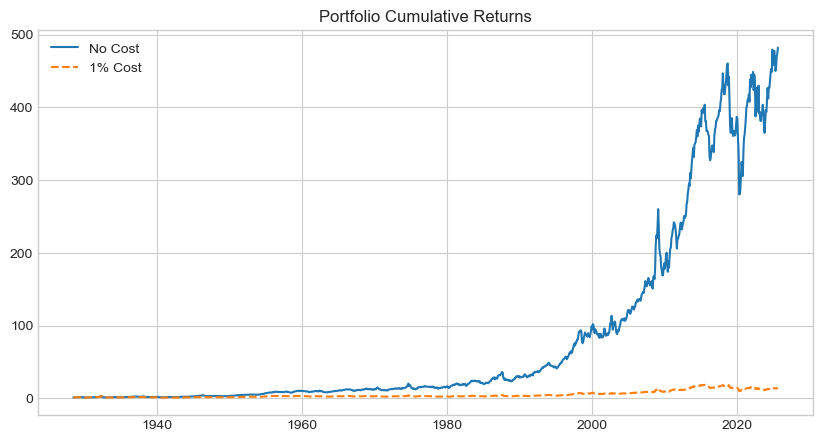

In [42]:
# --- 7. Performance Metrics ---
def performance_stats(returns):
    mean_ret = returns.mean() * 12
    vol = returns.std() * np.sqrt(12)
    sharpe = mean_ret / vol
    cumret = (1 + returns).cumprod()
    mdd = 1 - cumret / cumret.cummax()
    max_dd = mdd.max()
    return {"Annual Return": mean_ret, "Volatility": vol, "Sharpe": sharpe, "MaxDD": max_dd}

stats_no_cost = performance_stats(returns_no_cost)
stats_cost = performance_stats(returns_cost)

print("Performance (No Cost):", stats_no_cost)
print("Performance (1% Cost):", stats_cost)

# Plot cumulative returns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot((1+returns_no_cost).cumprod(), label="No Cost")
plt.plot((1+returns_cost).cumprod(), label="1% Cost", linestyle="--")
plt.title("Portfolio Cumulative Returns")
plt.legend()
plt.show()

In [43]:
# --- 8. Risk Metrics: VaR and ES ---
def compute_var_es(returns, var_level=0.01, es_level=0.05):
    var = np.quantile(returns, var_level)
    es = returns[returns <= np.quantile(returns, es_level)].mean()
    return var, es

var99, es95 = compute_var_es(returns_no_cost, 0.01, 0.05)
print(f"VaR(99%)={var99:.4f}, ES(95%)={es95:.4f}")

VaR(99%)=-0.1355, ES(95%)=-0.1127


In [44]:
# --- 9. VaR Backtesting (Kupiec Test) ---
from scipy.stats import chi2

def kupiec_test(returns, var_level=0.01):
    breaches = (returns < np.quantile(returns, var_level)).astype(int)
    x = breaches.sum()
    T = len(breaches)
    p_hat = x / T
    LR = -2 * (np.log((1 - var_level)**(T - x) * var_level**x) - np.log((1 - p_hat)**(T - x) * p_hat**x))
    p_value = 1 - chi2.cdf(LR, 1)
    return {"breaches": x, "total": T, "LR": LR, "p_value": p_value}

kupiec_result = kupiec_test(returns_no_cost)
print("Kupiec VaR Backtest:", kupiec_result)

Kupiec VaR Backtest: {'breaches': np.int64(12), 'total': 1166, 'LR': np.float64(0.009919406414525156), 'p_value': np.float64(0.9206648973945877)}


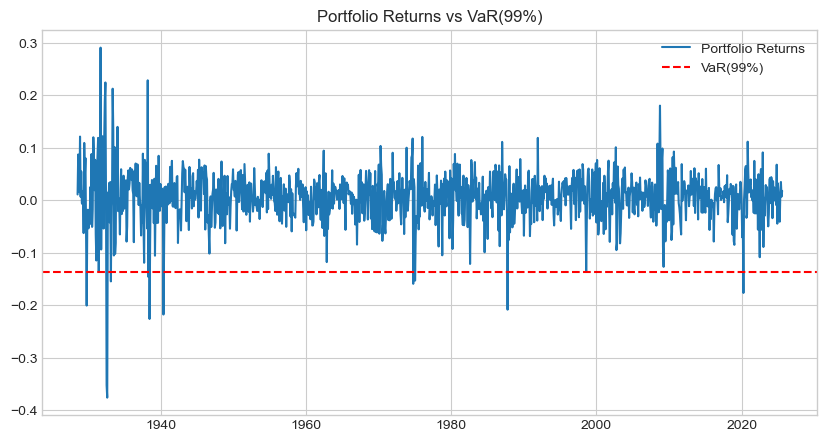

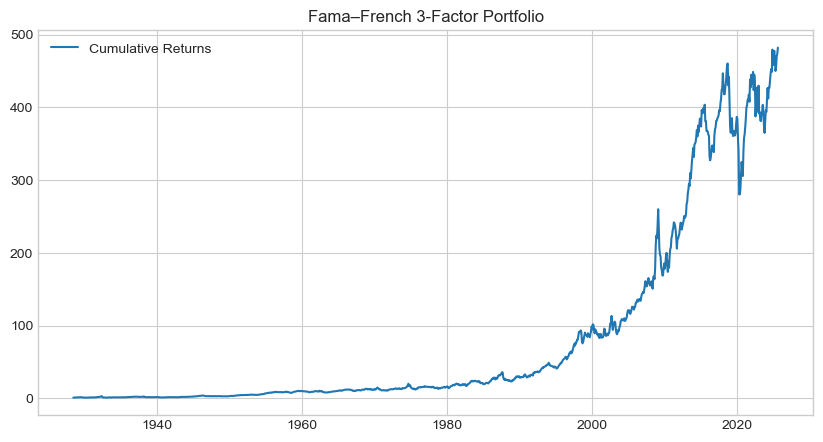

In [45]:
# --- 10. Visualization ---
plt.figure(figsize=(10,5))
plt.plot(returns_no_cost.index, returns_no_cost, label="Portfolio Returns")
plt.axhline(y=var99, color="r", linestyle="--", label="VaR(99%)")
plt.title("Portfolio Returns vs VaR(99%)")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot((1+returns_no_cost).cumprod(), label="Cumulative Returns")
plt.title("Fama–French 3-Factor Portfolio")
plt.legend()
plt.show()

In [47]:
weights

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1928-07-01,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1928-08-01,0.105509,0.124313,0.128548,0.031055,0.114473,0.07789,0.128939,0.101139,0.108682,0.079451
1928-09-01,0.10661,0.125047,0.127087,0.041924,0.116961,0.08361,0.118178,0.081096,0.105565,0.093923
1928-10-01,0.115129,0.10226,0.115486,0.052124,0.107976,0.093422,0.108897,0.097631,0.111793,0.095282
1928-11-01,0.107917,0.101891,0.129725,0.057542,0.107035,0.090961,0.10301,0.079292,0.115874,0.106754
...,...,...,...,...,...,...,...,...,...,...
2025-04-01,0.144835,-0.159441,0.087026,0.136988,0.009127,0.136808,0.030591,0.161866,0.076613,0.056705
2025-05-01,0.113818,-0.092906,0.113404,0.062307,0.077889,0.122389,0.086721,0.182916,0.061257,0.086393
2025-06-01,0.092715,-0.063548,0.115603,0.064973,0.104514,0.123578,0.103354,0.177721,0.061318,0.092676


In [ ]:
# analyse

# --- Merge all relevant data for analysis ---

# Make sure your datasets are already cleaned:
# factors: index=Date, columns=['Mkt-RF','SMB','HML','RF']
# industries: index=Date, columns=['NoDur', 'Durbl', ..., 'Other']
# predicted_returns: index=Date, columns=industry_cols
# weights: index=Date, columns=industry_cols
# returns_no_cost: Series with portfolio returns (no cost)
# returns_cost: Series with portfolio returns (1% cost)

# 1. Combine factors and industry returns
data_combined = industries.copy()
for col in factors.columns:
    data_combined[col] = factors[col]

# 2. Add predicted returns
for col in predicted_returns.columns:
    data_combined[f'pred_{col}'] = predicted_returns[col]

# 3. Add portfolio weights (no cost)
for col in weights.columns:
    data_combined[f'w_{col}'] = weights[col]

# 4. Add portfolio returns
data_combined['port_ret_no_cost'] = returns_no_cost
data_combined['port_ret_cost'] = returns_cost

# Optional: reset index for easy copying
data_combined = data_combined.reset_index()

# 5. Show first 10 rows and export as CSV string (if needed)
# print(data_combined.head(10))

# 6. Export to CSV string to paste
csv_string = data_combined.to_csv(index=False)
# print(csv_string[:1000])  # print first 1000 chars to check


DatetimeIndex(['1926-07-01', '1926-08-01', '1926-09-01', '1926-10-01',
               '1926-11-01', '1926-12-01', '1927-01-01', '1927-02-01',
               '1927-03-01', '1927-04-01',
               ...
               '2024-11-01', '2024-12-01', '2025-01-01', '2025-02-01',
               '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01',
               '2025-07-01', '2025-08-01'],
              dtype='datetime64[ns]', name='Date', length=1190, freq=None)
DatetimeIndex(['1926-07-01', '1926-08-01', '1926-09-01', '1926-10-01',
               '1926-11-01', '1926-12-01', '1927-01-01', '1927-02-01',
               '1927-03-01', '1927-04-01',
               ...
               '2024-11-01', '2024-12-01', '2025-01-01', '2025-02-01',
               '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01',
               '2025-07-01', '2025-08-01'],
              dtype='datetime64[ns]', name='Date', length=1190, freq=None)
             NoDur  Durbl  Manuf   Enrgy   HiTec   Telcm   Shops    Hl

In [72]:
# Reset index to column for merging
industries_reset = industries.reset_index()
factors_reset = factors.reset_index()
predicted_reset = predicted_returns.reset_index()
weights_reset = weights.reset_index()
returns_no_cost_reset = returns_no_cost.reset_index()
returns_cost_reset = returns_cost.reset_index()

# Rename columns to avoid collisions
predicted_reset = predicted_reset.rename(columns={c: f"pred_{c}" for c in industry_cols})
weights_reset = weights_reset.rename(columns={c: f"w_{c}" for c in industry_cols})
returns_no_cost_reset = returns_no_cost_reset.rename(columns={0: "port_ret_no_cost"})
returns_cost_reset = returns_cost_reset.rename(columns={0: "port_ret_cost"})

# Merge step by step on 'Date'
merged = industries_reset.merge(factors_reset, on="Date", how="inner")
merged = merged.merge(predicted_reset, on="Date", how="inner")
merged = merged.merge(weights_reset, on="Date", how="inner")
merged = merged.merge(returns_no_cost_reset, on="Date", how="inner")
merged = merged.merge(returns_cost_reset, on="Date", how="inner")

merged.to_csv('result.csv')


In [73]:
import numpy as np

# Use your merged dataframe
# 'port_ret_no_cost', 'port_ret_cost' columns
portfolio_ret = data_combined['port_ret_no_cost']

# 1. Performance metrics
ann_return = portfolio_ret.mean() * 12
ann_vol = portfolio_ret.std() * np.sqrt(12)
sharpe = ann_return / ann_vol
cum_return = (1 + portfolio_ret).cumprod().iloc[-1]
drawdown = 1 - (1 + portfolio_ret).cumprod() / (1 + portfolio_ret).cumprod().cummax()
max_dd = drawdown.max()

# 2. Risk metrics
var99 = np.quantile(portfolio_ret, 0.01)
es95 = portfolio_ret[portfolio_ret <= np.quantile(portfolio_ret, 0.05)].mean()

# 3. Portfolio allocation metrics
weight_cols = [c for c in data_combined.columns if c.startswith('w_')]
avg_weights = data_combined[weight_cols].mean()
turnover = data_combined[weight_cols].diff().abs().sum().mean()  # average monthly turnover

# 4. Factor exposures (optional)
factor_cols = ['Mkt-RF', 'SMB', 'HML']
beta_exposure = []
for factor in factor_cols:
    # Regression of portfolio excess return vs factor
    X = data_combined[factor]
    y = portfolio_ret - data_combined['RF']  # excess return
    beta = np.cov(y, X)[0,1] / np.var(X)
    beta_exposure.append(beta)

# Print summary
print("Annualized Return:", ann_return)
print("Annualized Volatility:", ann_vol)
print("Sharpe Ratio:", sharpe)
print("Max Drawdown:", max_dd)
print("Cumulative Return:", cum_return)
print("VaR(99%):", var99)
print("ES(95%):", es95)
print("Average Weights:\n", avg_weights)
print("Average Turnover:", turnover)
print("Factor Exposures (Mkt, SMB, HML):", beta_exposure)


Annualized Return: 0.07870530191249359
Annualized Volatility: 0.16997618076313747
Sharpe Ratio: 0.463037241801366
Max Drawdown: 0.6570389077873766
Cumulative Return: 482.2736166031194
VaR(99%): nan
ES(95%): nan
Average Weights:
 w_NoDur    0.050675
w_Durbl    0.030923
w_Manuf    0.051039
w_Enrgy    0.039474
w_HiTec    0.043204
w_Telcm    0.042242
w_Shops    0.043872
w_Hlth     0.042895
w_Utils    0.041083
w_Other    0.056898
dtype: object
Average Turnover: 35.45193417403671
Factor Exposures (Mkt, SMB, HML): [np.float64(nan), np.float64(nan), np.float64(nan)]


Where this code could be improved — concrete suggestions

I'll split improvements into modeling, robustness/validation, production & performance, and research extensions.

1) Modeling & statistical improvements

Use rolling OLS with regularization: OLS on small windows can be noisy. Use ridge regression or shrinkage (e.g., James-Stein) to reduce estimation error in betas.

Model factor expected returns more carefully: The code uses long-run mean of factors. Instead consider:

Exponentially weighted means,

Predictive models for factor premia (time-series models, macro regressors),

Bayesian shrinkage for factor forecasts.

Heteroskedasticity-robust inference: use Newey–West on beta estimates if you perform hypothesis tests.

Allow for long-short portfolios: currently targets long-only by clipping negative ER/vol. To match institutional practice allow short positions with constraints (leverage/cap limits).

Market neutral / constrained optimizations: Rather than naive ER/vol weighting, solve a constrained mean-variance or RORAC optimization (use CVXOPT or scipy.optimize) with risk budget constraints.

2) Backtest realism & robustness

Transaction cost model: 1% flat proportional is simplistic. Add:

Bid-ask spread model,

Market impact (nonlinear cost with turnover),

Slippage and minimum trade sizes.

Execution timing: The script assumes weights at the start of the period. Add realistic timing (signal at close, trade next open).

Survivorship bias & lookahead: Make sure asset universe is consistent. Use CRSP / WRDS to avoid survivorship bias.

Out-of-sample splits and cross-validation: Use a clear train/validation/test split for tuning (e.g., window for estimation, next X months for validation).

Transaction constraints & realistic rebalancing schedule: Use thresholded rebalancing to reduce turnover (only rebalance when weight deviation exceeds threshold).

3) Risk measures & backtesting

Better VaR/ES estimation:

Use filtered historical simulation (FHS) with GARCH-filtered residuals to capture time-varying volatility.

Use extreme value theory (EVT) to better estimate tail risk.

Backtesting: Augment Kupiec with Christoffersen’s interval forecast test (tests independence of violations) and traffic-light tests for regulatory style evaluation.

Scenario analysis & stress testing: compute portfolio losses under historical stressful scenarios (e.g., 2008, COVID-19) and test sensitivity to factor shocks.

4) Implementation, performance & reproducibility

Vectorize & optimize: replace Python loops in rolling OLS with batch matrix operations or use statsmodels rolling wrappers / numpy.linalg.lstsq for speed.

Parallelization: estimate betas per asset in parallel (joblib / multiprocessing) for large universes.

Unit tests and CI: write unit tests for functions (pytest) to ensure correctness during refactor.

Notebook & reproducibility: create a clear Jupyter notebook main.ipynb with cells for each step; store intermediate artifacts (betas, weights) as pickle files for reproducibility.

Logging & diagnostics: add logging for regressions that fail, number of NaNs, turnover spikes.

Packaging: modularize into a pip-installable package or project with setup.cfg for reuse.

5) Research & extensions (makes CV/Interview talking points)

Extend to multi-factor or region-specific FF models: e.g., Fama–French 5-factor, Carhart 4-factor, or region-specific factor sets.

Add macro / term structure factors for fixed income: incorporate rates, carry, term premium signals to reflect fixed-income remit in the JD.

Factor timing & regime switching: detect regimes (via HMM or clustering) and adapt factor exposures.

Stochastic volatility / GARCH: use GARCH to model conditional vol for better risk forecasting.

Interpretability: provide factor attribution (contribution of each factor to P&L) and a clear story linking factor exposures to macro drivers.